In [1]:
%%time
# Standard library imports
import os

# Third-party imports
import tifffile
import matplotlib.pyplot as plt
import numpy as np

# ClearEx library imports
from clearex.registration import ChunkedImageRegistration
# from tests import download_test_registration_data


CPU times: user 649 ms, sys: 341 ms, total: 990 ms
Wall time: 3.95 s


In [2]:
# %%time
# output_path = download_test_registration_data()
#
# # Define file paths for fixed and moving images
# fixed_path = os.path.join(
#     output_path,
#     "cropped_fixed.tif")
#
# moving_path = os.path.join(
#     output_path,
#     "cropped_moving.tif")
#
# transform_path = os.path.join(
#     output_path,
#     "GenericAffine.mat")
#
# transform_list = [transform_path]

In [4]:
imaging_round = 3
data_directory = "/archive/bioinformatics/Danuser_lab/Dean/dean/2025-11-18"

data = {
    1: "round1_488_tubulin.tif",
    3: "round3_488_tubulin.tif",
    4: "round4_555_tubulin.tif",
    5: "round5_555_tubulin.tif",
    6: "round6_488_tubulin.tif",
    7: "round7_488_tubulin.tif",
    8: "round8_488_tubulin.tif",
    9: "round9_488_tubulin.tif"
}

fixed_path = os.path.join(data_directory, data[1])
moving_path = os.path.join(data_directory, data[imaging_round])
output_path = "/archive/bioinformatics/Danuser_lab/Dean/dean/2025-11-28"



In [5]:
%%time
# Create a ChunkedImageRegistration instance
registrar = ChunkedImageRegistration(
    fixed_image_path=fixed_path,
    moving_image_path=moving_path,
    save_directory=output_path,
    imaging_round=1,
    crop=True,
    enable_logging=True
)

# Set chunk parameters (optional - defaults are already set)
registrar.chunk_size = (512, 512, 512)  # Adjust based on your data size
registrar.overlap_fraction = 0.15
registrar.linear_accuracy = "dry run"
registrar.nonlinear_accuracy = "dry run"

print(f"Fixed image shape: {registrar.fixed_image_info.shape}")
print(f"Moving image shape: {registrar.moving_image_info.shape}")


2025-11-29 08:25:07,921 - INFO - Image registration performed with antspyx: 0.6.1
2025-11-29 08:25:07,922 - INFO - Opening /archive/bioinformatics/Danuser_lab/Dean/dean/2025-11-18/round1_488_tubulin.tif
2025-11-29 08:25:07,922 - INFO - Using reader: TiffReader.
2025-11-29 08:25:10,108 - INFO - Loaded round1_488_tubulin.tif as NumPy array.
2025-11-29 08:25:10,110 - INFO - Opening /archive/bioinformatics/Danuser_lab/Dean/dean/2025-11-18/round3_488_tubulin.tif
2025-11-29 08:25:10,110 - INFO - Using reader: TiffReader.
2025-11-29 08:25:11,621 - INFO - Loaded round3_488_tubulin.tif as NumPy array.
2025-11-29 08:25:11,622 - INFO - Loaded fixed image /archive/bioinformatics/Danuser_lab/Dean/dean/2025-11-18/round1_488_tubulin.tif. Shape: (287, 2834, 2048).
2025-11-29 08:25:11,622 - INFO - Loaded moving image /archive/bioinformatics/Danuser_lab/Dean/dean/2025-11-18/round3_488_tubulin.tif. Shape: (287, 2834, 2048).
2025-11-29 08:25:11,623 - INFO - Identifying minimal bounding box for cropping...

In [5]:
%%time
# Perform the full registration (linear + chunked nonlinear)
registrar.register()

print("\nRegistration complete!")
print(f"Output directory: {output_path}")


2025-11-27 14:56:36,235 - INFO - Linear transformation already exists at /archive/bioinformatics/Danuser_lab/Dean/dean/2025-11-25-chunked-registration/linear_transform_1.mat. Skipping registration.
2025-11-27 14:56:48,579 - INFO - Beginning Chunked Nonlinear Registration...
2025-11-27 14:56:48,580 - INFO - Computing Chunk Grid
2025-11-27 14:56:48,580 - INFO - Image shape: (111, 2293, 1681)
2025-11-27 14:56:48,581 - INFO - Chunk size: (512, 512, 512)
2025-11-27 14:56:48,581 - INFO - Overlap: (76, 76, 76)
2025-11-27 14:56:48,581 - INFO - Created 24 chunks
2025-11-27 14:56:48,581 - INFO - Grid dimensions: 1 x 6 x 4
2025-11-27 14:56:49,318 - INFO - Chunk 1/24
2025-11-27 14:56:49,319 - INFO - Processing chunk 0...
2025-11-27 14:56:49,320 - INFO -   Found existing transform for chunk 0. Loading...
2025-11-27 14:56:49,321 - INFO -   Chunk 0: fixed_chunk shape=(111, 550, 550), moving_chunk shape=(111, 550, 550)
2025-11-27 14:57:00,635 - INFO -   Loaded and applied existing transform: /archive/

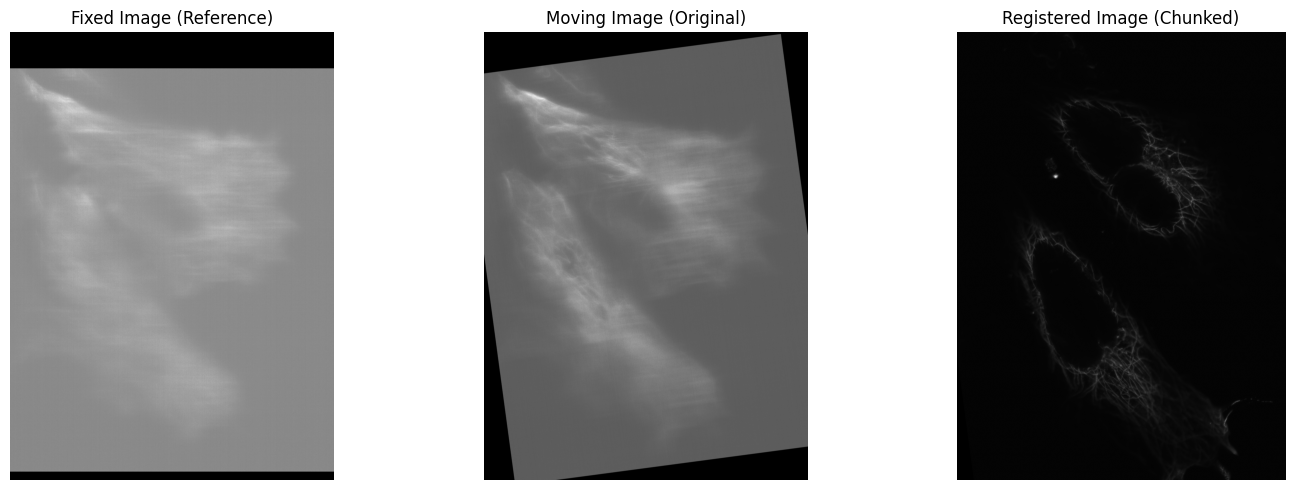

CPU times: user 2.18 s, sys: 2.35 s, total: 4.53 s
Wall time: 6.74 s


In [6]:
%%time
# Load and visualize results
registered_image = tifffile.imread(
    os.path.join(output_path, "nonlinear_registered_1.tif")
)

# Display middle slices
z_mid = registered_image.shape[0] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Fixed image
fixed_img = tifffile.imread(fixed_path)
axes[0].imshow(fixed_img[z_mid], cmap='gray')
axes[0].set_title('Fixed Image (Reference)')
axes[0].axis('off')

# Moving image (original)
moving_img = tifffile.imread(moving_path)
axes[1].imshow(moving_img[z_mid], cmap='gray')
axes[1].set_title('Moving Image (Original)')
axes[1].axis('off')

# Registered image
axes[2].imshow(registered_image[z_mid], cmap='gray')
axes[2].set_title('Registered Image (Chunked)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [7]:
%%time
# Create colorblind-friendly overlay to visualize registration quality
# Using magenta (fixed) and cyan (registered) which are distinguishable for colorblind viewers

# Normalize images to 0-1 range for visualization
def normalize_image(img):
    img_min, img_max = img.min(), img.max()
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    return img

fixed_norm = normalize_image(np.max(fixed_img, axis=1))
registered_norm = normalize_image(np.max(registered_image, axis=1))

# Create RGB overlay
# Magenta = Red + Blue, Cyan = Green + Blue
# Where images match, you'll see white/gray
# Where they differ: magenta shows fixed, cyan shows registered
overlay = np.zeros((*fixed_norm.shape, 3))
overlay[:, :, 0] = fixed_norm          # Red channel: fixed image
overlay[:, :, 1] = registered_norm      # Green channel: registered image
overlay[:, :, 2] = (fixed_norm + registered_norm) / 2  # Blue channel: average

# Also create a difference map
difference = np.abs(fixed_norm - registered_norm)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Overlay visualization
axes[0].imshow(overlay)
axes[0].set_title('Overlay: Magenta=Fixed, Cyan=Registered, White=Match')
axes[0].axis('off')

# Difference map
im = axes[1].imshow(difference, cmap='viridis')  # viridis is colorblind-friendly
axes[1].set_title('Absolute Difference (darker = better match)')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Mean absolute difference: {difference.mean():.6f}")
print(f"Max absolute difference: {difference.max():.6f}")


CPU times: user 349 ms, sys: 0 ns, total: 349 ms
Wall time: 349 ms


ValueError: could not broadcast input array from shape (111,1681) into shape (287,2048)